In [1]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score
from tabulate import tabulate  # For table formatting

from plotly import express as px

from utils import plot_confusion_matrix, get_artifact_filename

import os

from json import loads

from joblib import load, dump

import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

c:\anaconda3\envs\ldi2_cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Paths
BASE_DIR = '../'
PATH_TO_TRAIN = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train.csv")
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")

## (0) Modelo Tabulares Base
Variables originales del dataset, sin feature engineering.

In [4]:
study_lgb_base = optuna.create_study(direction='maximize',
                            storage="sqlite:///../work/db.sqlite3",  # Specify the storage URL here.
                            study_name="04 - LGB Multiclass - Base",
                            load_if_exists = True)

# Get the artifact filename
artifact_filename = get_artifact_filename(study_lgb_base,'test')

# Combine the path and filename
artifact_path = os.path.join(PATH_TO_OPTUNA_ARTIFACTS, artifact_filename)


lgb_base_ds = load(artifact_path)

[I 2024-10-17 18:57:31,852] Using an existing study with name '04 - LGB Multiclass - Base' instead of creating a new one.


In [5]:
# Renombro algunas variables del dataset
lgb_base_dataset = lgb_base_ds[['PetID', 'pred', 'AdoptionSpeed']].rename({'pred':'lgb_base_pred_score'},axis=1)

# Creo las velocidades predichas por el modelo base
lgb_base_dataset['lgb_base_pred'] = [r.argmax() for r in lgb_base_dataset['lgb_base_pred_score']]

plot_confusion_matrix(lgb_base_dataset['AdoptionSpeed'],
                      lgb_base_dataset['lgb_base_pred'], 
                    title = 'LGB Base Model Kappa: ' + str(cohen_kappa_score(lgb_base_dataset['AdoptionSpeed'],
                                                                    lgb_base_dataset['lgb_base_pred'], 
                                                                    weights='quadratic')))

## (1) Modelo Tabulares con FE
Variables originales + nuevas variables creadas

In [6]:
study_lgb = optuna.create_study(direction='maximize',
                            storage="sqlite:///../work/db.sqlite3",  # Specify the storage URL here.
                            study_name="04 - LGB Multiclass - FE v4",
                            load_if_exists = True)

# Get the artifact filename
artifact_filename = get_artifact_filename(study_lgb,'test')
print(artifact_filename)

# Combine the path and filename
artifact_path = os.path.join(PATH_TO_OPTUNA_ARTIFACTS, artifact_filename)

print(os.path.exists(PATH_TO_OPTUNA_ARTIFACTS))
print(os.path.normpath(artifact_path))
print(os.path.exists(artifact_path))


lgb_dataset = load(artifact_path)

[I 2024-10-17 18:57:32,364] Using an existing study with name '04 - LGB Multiclass - FE v4' instead of creating a new one.


af4eeddd-1a3b-40fe-b0c5-71d246b8737b
True
..\work\optuna_artifacts\af4eeddd-1a3b-40fe-b0c5-71d246b8737b
True


In [7]:
lgb_dataset.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,RescuerID_full_health_ratio,RescuerID_mean_description_length,RescuerID_dog_ratio,RescuerID_breed_specialization,prediction_class_0,prediction_class_1,prediction_class_2,prediction_class_3,prediction_class_4,pred
14696,1,Dione & Elora,1,307,307,2,1,0,0,2,...,0.0,148.90,1.00,1.00,0.002637,0.156636,0.266874,0.471452,0.102400,"[0.048073917012569856, 0.6640418131498907, 2.7..."
14823,1,Har-nee,24,103,307,2,1,2,4,2,...,0.0,838.00,1.00,1.00,0.016761,0.166559,0.207251,0.194078,0.415351,"[0.10797798623303964, 1.3892475235353483, 1.40..."
2838,1,The Gorgeous 5 Beauties,2,307,0,2,2,7,0,2,...,0.0,608.75,0.75,0.75,0.019105,0.204035,0.353514,0.259572,0.163773,"[0.07731425046131762, 0.81667288617089, 1.8162..."
1848,2,Mochi,1,265,0,1,2,0,0,1,...,0.0,1207.20,0.00,0.80,0.017194,0.299177,0.536504,0.100774,0.046351,"[0.11554058802928632, 1.3834160895753955, 2.18..."
669,2,Nala & Peach,9,266,266,2,2,4,6,2,...,0.0,242.00,0.00,1.00,0.008867,0.044874,0.324296,0.202780,0.419182,"[0.07624731761282272, 0.40313580904130275, 0.8..."


## (2) Modelo ResNet (imágenes)

In [8]:
MODEL_NAME = '04 ResNet'
MODEL_VERSION = '5.0.1'

study_resnet = optuna.create_study(direction='maximize',
                            storage="sqlite:///../work/db.sqlite3",  # Specify the storage URL here.
                            study_name=f'{MODEL_NAME}_{MODEL_VERSION}',
                            load_if_exists = True)

resnet_dataset = load(os.path.join(PATH_TO_OPTUNA_ARTIFACTS,get_artifact_filename(study_resnet,'test')))

[I 2024-10-17 18:57:32,469] Using an existing study with name '04 ResNet_5.0.1' instead of creating a new one.


In [9]:
resnet_dataset.head()

,PetID,pred,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed
0,015da9e87,"[-1.768325, 0.18485203, 0.74715734, 0.3766706,...",2,Adik Gebuk (Betina),2,265,266,2,2,5,...,2,1,1,0,41326,d718a8deb57887c6ee18b757484273c8,0,Nama: Gebuk (Betina)- Adik beradik dengan Gebu...,5.0,0
1,022606901,"[-3.3611686, -0.36317593, 0.7986378, 0.9519239...",1,NaN,3,141,307,1,1,0,...,2,1,1,0,41401,c4b8b921e00ba5dc19e793b81987f40f,1,Hi all =) My friend is currently looking for s...,5.0,0
2,02f89bdcb,"[-3.027864, -0.031935632, 0.49349236, 0.814333...",1,Rex,72,141,0,1,5,0,...,2,1,1,0,41326,e76b700e2c869088979aa5efeb962dd7,0,Friendly and playful. Good watchdog because of...,3.0,0
3,0cf7fae9d,"[-0.7027494, 1.0775297, 0.5501126, -0.03754511...",2,KITTENS - URGENT ADOPTION,1,266,0,3,1,2,...,2,1,4,0,41326,1eea485b01d14c668f33afa7c919646e,0,These 4 kittens need urgent adoption because t...,1.0,0
4,0e922caab,"[-0.40759718, 1.3669151, 0.54109144, -0.100735...",1,Ha Ha (Toy Poodle),12,179,0,1,2,0,...,2,1,1,300,41326,225d19c861c7c5d20a9c3ba1b2d37753,0,Ha Ha belongs to my friend who migrated to ano...,5.0,0


## (3) Modelo Bert (texto)

In [10]:
MODEL_NAME = '06 Bert'
MODEL_VERSION = '4.0'

study_bert = optuna.create_study(direction='maximize',
                            storage="sqlite:///../work/db.sqlite3",  # Specify the storage URL here.
                            study_name=f'{MODEL_NAME}_{MODEL_VERSION}',
                            load_if_exists = True)

bert_dataset = load(os.path.join(PATH_TO_OPTUNA_ARTIFACTS,get_artifact_filename(study_bert,'test')))

[I 2024-10-17 18:57:32,574] Using an existing study with name '06 Bert_4.0' instead of creating a new one.


In [11]:
bert_dataset.head()

,PetID,pred,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed,labels
0,8e76c8e39,"[0.010217882, 0.002740395, 0.031425107, 0.1316...",2,Kali,3,264,0,2,1,2,...,1,1,50,41326,a9caef3f98e67bfac9093cca79e20b93,0,Kali is a super playful kitten who is on the g...,2.0,1,1
1,6436c1a59,"[4.1448016e-05, 0.00016069962, 0.020254172, 0....",1,Godiva,12,307,0,2,2,7,...,1,1,0,41326,a042471e0f43f2cf707104a1a138a7df,0,Godiva was rescued in Serdang residential area...,7.0,2,2
2,988988d5b,"[0.0031289272, 0.3546625, 0.34136075, 0.299003...",2,Cikenet,3,266,0,1,2,7,...,1,1,0,41401,b8853c71b981104f1ef126e51387b616,0,"hello cikenets fans, i just wanna inform that ...",19.0,1,1
3,efbf1703a,"[0.0038808198, 0.03597094, 0.05675837, 0.07370...",2,No Name,1,266,0,2,1,0,...,1,1,0,41326,2f846fb8f87a25678374e193559d83c9,0,"Just saved this kitten from the street, but i ...",2.0,2,2
4,543130f60,"[0.07851128, 0.016772442, 0.84724694, 0.053508...",1,BoiBoi,24,307,0,1,5,7,...,1,5,0,41326,2147467fcd35e7a3bc23b9edcffc5702,0,Boiboi is rescued by my daughter 2 years ago f...,1.0,4,4


### Combino todos los resultados de los modelos en un unico df

In [12]:
# Combino LGB con ResNet
merged_datasets = lgb_dataset[['PetID', 'pred', 'AdoptionSpeed']].rename({'pred':'lgb_pred_score'},axis=1).merge(resnet_dataset[['PetID', 'pred']].rename({'pred':'resnet_pred_score'},axis=1),
                  on='PetID', how='outer')
# Combino el data set con Bert
merged_datasets = merged_datasets.merge(bert_dataset[['PetID', 'pred']].rename({'pred':'bert_pred_score'},axis=1),
                  on='PetID', how='outer')

merged_datasets['resnet_pred_score'] = [np.zeros(5) if type(i) is float else  i for i in merged_datasets['resnet_pred_score'] ]
merged_datasets['bert_pred_score'] = [np.zeros(5) if type(i) is float else  i for i in merged_datasets['bert_pred_score'] ]

In [13]:
merged_datasets['blend_pred_score'] = [r['lgb_pred_score']+r['resnet_pred_score']+r['bert_pred_score'] for i,r in merged_datasets.iterrows()]

merged_datasets['resnet_bert_pred_score'] = [r['resnet_pred_score']+r['bert_pred_score'] for i,r in merged_datasets.iterrows()]

In [14]:
# Creo las velocidades predichas para cada modelo
merged_datasets['lgb_pred'] = [r.argmax() for r in merged_datasets['lgb_pred_score']]
merged_datasets['resnet_pred'] = [r.argmax() for r in merged_datasets['resnet_pred_score']]
merged_datasets['bert_pred'] = [r.argmax() for r in merged_datasets['bert_pred_score']]

# Creo la velocidad predicha para el modelo combinado
merged_datasets['blended_pred'] = [r.argmax() for r in merged_datasets['blend_pred_score']]

# Creo la velocidad predicha para el modelo Resnet+Bert
merged_datasets['resnet_bert_pred'] = [r.argmax() for r in merged_datasets['resnet_bert_pred_score']]

In [15]:
plot_confusion_matrix(merged_datasets['AdoptionSpeed'],
                      merged_datasets['lgb_pred'], 
                    title = 'LGB Model Kappa: ' + str(cohen_kappa_score(merged_datasets['AdoptionSpeed'],
                                                                    merged_datasets['lgb_pred'], 
                                                                    weights='quadratic')))

In [16]:
plot_confusion_matrix(merged_datasets['AdoptionSpeed'],
                      merged_datasets['resnet_pred'], 
                    title = 'Resnet Model Kappa: ' + str(cohen_kappa_score(merged_datasets['AdoptionSpeed'],
                                                                    merged_datasets['resnet_pred'], 
                                                                    weights='quadratic')))



In [17]:
plot_confusion_matrix(merged_datasets['AdoptionSpeed'],
                      merged_datasets['bert_pred'], 
                    title = 'Bert Model Kappa: ' + str(cohen_kappa_score(merged_datasets['AdoptionSpeed'],
                                                                    merged_datasets['bert_pred'], 
                                                                    weights='quadratic')))


In [18]:
plot_confusion_matrix(merged_datasets['AdoptionSpeed'],
                      merged_datasets['blended_pred'], 
                    title = 'Blended Model Kappa: ' + str(cohen_kappa_score(merged_datasets['AdoptionSpeed'],
                                                                    merged_datasets['blended_pred'], 
                                                                    weights='quadratic')))


In [44]:
# Creamos metricas para comparar los modelos

# Define the true labels
true_labels = merged_datasets['AdoptionSpeed']

# Define the prediction columns
prediction_columns = ['lgb_pred', 'resnet_pred', 'bert_pred', 'blended_pred']

# Initialize dictionaries to store metrics for each prediction column
accuracy_dict = {}
f1_dict = {}
precision_dict = {}
kappa_dict = {}
caccuracy_dict = {}

# Definir la métrica personalizada segun cercania (+- 1)
def close_accuracy(true_labels, predictions):
    """
    Calcula la métrica de 'cercanía' donde se considera aceptable una predicción si está a ±1 del valor correcto.
    """
    close_preds = np.abs(true_labels - predictions) <= 1  # Verifica si la predicción está a ±1 del valor real
    return np.mean(close_preds)  # Calcula el porcentaje de predicciones aceptables

# Calculate metrics for each prediction column
for pred_col in prediction_columns:
    predictions = merged_datasets[pred_col]
    
    # Compute metrics
    accuracy_dict[pred_col] = accuracy_score(true_labels, predictions)
    f1_dict[pred_col] = f1_score(true_labels, predictions, average='weighted')

    # Metrica especial de "cercania"
    caccuracy_dict[pred_col] = close_accuracy(true_labels, predictions)    
    
    # Quadratic Weighted Kappa
    kappa_dict[pred_col] = cohen_kappa_score(true_labels, predictions, weights='quadratic')

# Agrego el base LGBM model
base_lgbm_predictions = lgb_base_dataset['lgb_base_pred']

# Compute metrics for base LGBM model
accuracy_dict['base_lgbm_pred'] = accuracy_score(true_labels, base_lgbm_predictions)
f1_dict['base_lgbm_pred'] = f1_score(true_labels, base_lgbm_predictions, average='weighted')
caccuracy_dict['base_lgbm_pred'] = close_accuracy(true_labels, base_lgbm_predictions)
kappa_dict['base_lgbm_pred'] = cohen_kappa_score(lgb_base_dataset['AdoptionSpeed'],
                                                                    lgb_base_dataset['lgb_base_pred'], 
                                                                    weights='quadratic')

# Insert the base LGBM model at the first position in the prediction_columns list
prediction_columns.insert(0, 'base_lgbm_pred')

# Create a table with the results
table_data = [
    ['Quadratic Weighted Kappa', *[kappa_dict[col] for col in prediction_columns]],
    ['F1 Score', *[f1_dict[col] for col in prediction_columns]],
    ['Accuracy', *[accuracy_dict[col] for col in prediction_columns]],
    ['Close Accuracy', *[caccuracy_dict[col] for col in prediction_columns]]
]

# Display the table
headers = ['Metric'] + prediction_columns
print(tabulate(table_data, headers=headers, floatfmt=".4f"))

Metric                      base_lgbm_pred    lgb_pred    resnet_pred    bert_pred    blended_pred
------------------------  ----------------  ----------  -------------  -----------  --------------
Quadratic Weighted Kappa            0.3260      0.3871         0.2356       0.2235          0.4086
F1 Score                            0.2499      0.4310         0.3212       0.3496          0.4323
Accuracy                            0.2684      0.4458         0.3334       0.3511          0.4502
Close Accuracy                      0.0653      0.7586         0.6799       0.7122          0.7686


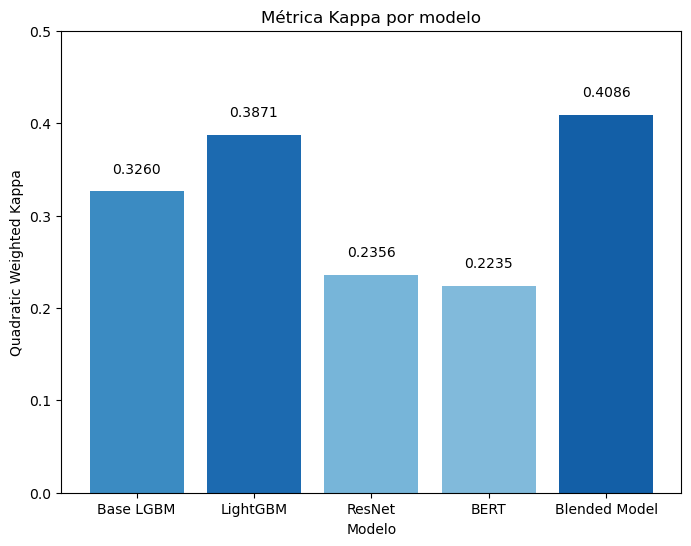

In [46]:
# Grafico con los Kappa cuadraticos de cada modelo

# Define a mapping for the display names of the models
model_names = {
    'base_lgbm_pred': 'Base LGBM',
    'lgb_pred': 'LightGBM',
    'resnet_pred': 'ResNet',
    'bert_pred': 'BERT',
    'blended_pred': 'Blended Model'
}

# Replace the column names in prediction_columns with the display names
renamed_columns = [model_names.get(col, col) for col in prediction_columns]

# Extract the Quadratic Weighted Kappa values
kappa_values = table_data[0][1:]  # The first row (excluding 'Metric') contains the Kappa values

# Normalize kappa values to map colors (between 0 and 1)
norm = plt.Normalize(0, 0.5)

# Get a colormap (e.g., 'Blues', 'Greens', 'Oranges', etc.)
cmap = plt.get_cmap('Blues')  # You can choose 'Blues', 'Greens', 'Oranges', etc.

# Generate colors based on kappa values
colors = cmap(norm(kappa_values))

# Plotting the bar chart with intensity-based colors
plt.figure(figsize=(8, 6))
plt.bar(renamed_columns, kappa_values, color=colors)

# Add title and labels
plt.title('Métrica Kappa por modelo')
plt.xlabel('Modelo')
plt.ylabel('Quadratic Weighted Kappa')
plt.ylim(0, 0.5)

# Display the values on top of each bar
for i, value in enumerate(kappa_values):
    plt.text(i, value + 0.02, f'{value:.4f}', ha='center')

# Show the chart
plt.show()
